In [1]:
from lib.jianji.code_csf import csf
import torch 
from torch.utils.data import Dataset
from torch import nn
from d2l import torch as d2l

In [2]:
traindSet = csf(csv_path='original_train_set.pkl', mode='train')
trainloader =  torch.utils.data.DataLoader(traindSet, batch_size=256, drop_last=True, shuffle=True)

In [3]:
testset = csf(csv_path='original_valid_set.pkl', mode='valid')
testloader = torch.utils.data.DataLoader(testset, batch_size=256, drop_last=True, shuffle=True)

In [4]:
net = nn.Sequential(
    nn.Linear(152, 1024), nn.ReLU(),
    nn.Linear(1024, 2048), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(2048, 1024), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 512), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, 256), nn.ReLU(),
    nn.Linear(256, 64), nn.ReLU(),
    nn.Linear(64, 16), nn.ReLU(),
    nn.Linear(16, 1), nn.Sigmoid())

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            output = net(X)
            y_pred = torch.where(output>0.5,torch.ones_like(output),torch.zeros_like(output))
            metric.add(d2l.accuracy(y_pred, y), y.numel())
    return metric[0] / metric[1]

In [6]:
def continue_train(net, num_epochs, train_iter, test_iter, device):
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                train_acc_num = torch.where(y_hat>0.5,torch.ones_like(y_hat),torch.zeros_like(y_hat))
                metric.add(l * X.shape[0], d2l.accuracy(train_acc_num, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

KeyboardInterrupt: 

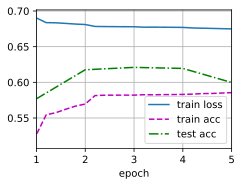

In [9]:
lr = 0.6
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[1, 5],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
net.to('cuda')
continue_train(net, 15, trainloader, testloader, d2l.try_gpu())

loss 0.290, train acc 0.875, test acc 0.498


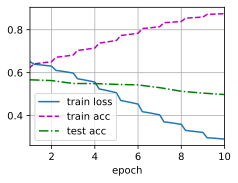

In [10]:
lr = 0.05
epochs = 10
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
num_batches = len(trainloader)
animator = d2l.Animator(xlabel='epoch', xlim=[1, 5],
                            legend=['train loss', 'train acc', 'test acc'])
loss = nn.BCELoss()
net.to('cuda')
continue_train(net, epochs, trainloader, testloader, d2l.try_gpu())

In [11]:
torch.save(net, 'over_fitted_model_0.875.pth')

In [8]:
d2l.try_gpu()

device(type='cuda', index=0)

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
df_list = []
for i in tqdm(range(1, 37)):
    str = f'./data_double_nucleotides/double_train_{i}_0.xlsx'
    df1 = pd.read_excel(str)
    new_columns = np.arange(76)
    df1.columns = new_columns
    df1.insert(df1.shape[1], 76, 0)
    df_list.append(df1)

  0%|                                                                                           | 0/36 [00:04<?, ?it/s]


ValueError: Length mismatch: Expected axis has 76 elements, new values have 152 elements

In [3]:
df_neg = pd.concat(df_list, axis=0)
df_neg.to_pickle('neg_original_valid.pkl')
df = pd.read_pickle('neg_original_valid.pkl')
df

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
0,4,1,1,1,4,1,3,3,4,4,...,4,4,1,2,4,3,1,4,1,0
1,2,2,3,3,3,2,4,4,3,1,...,4,2,1,4,1,4,3,4,4,0
2,1,3,3,4,3,4,1,2,2,1,...,4,4,1,4,4,4,3,2,3,0
3,1,4,1,4,4,4,3,2,3,2,...,3,4,4,2,1,2,1,4,4,0
4,3,3,2,1,1,3,3,1,3,4,...,4,2,1,3,3,2,1,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3891,3,1,2,2,1,1,3,4,2,4,...,1,3,3,3,4,1,1,2,1,0
3892,3,4,1,2,2,4,3,4,2,4,...,4,2,2,2,3,3,2,2,1,0
3893,2,4,4,1,2,2,4,4,4,1,...,4,3,2,4,1,3,2,3,2,0
3894,3,2,2,1,2,3,3,1,4,3,...,4,1,4,1,1,4,3,2,2,0


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
df_list = []
for i in tqdm(range(36, 41)):
    str = f'./data/train_{i}_1.xlsx'
    df1 = pd.read_excel(str)
    new_columns = np.arange(152)
    df1.columns = new_columns
    df1.insert(df1.shape[1], 152, 0)
    df_list.append(df1)
df_neg = pd.concat(df_list, axis=0)
df_neg.to_pickle('positive_valid.pkl')
df = pd.read_pickle('positive_valid.pkl')
df

 60%|█████████████████████████████████████████████████▊                                 | 3/5 [11:22<07:35, 227.70s/it]